# Total Divergence Potential

This notebook is for calculating total divergence potential vs pseudotime

### Data Preprocessing

In [1]:
import scvelo as scv
import scanpy as sc
import numpy as np
import sklearn
scv.set_figure_params()

In [2]:
adata = scv.datasets.pancreas()
adata_raw = adata.copy()

In [3]:
scv.pp.filter_and_normalize(adata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(adata_raw, log=False, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
Filtered out 20801 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
computing neighbors
    finished (0:00:25) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


recovering dynamics (using 2/28 cores)
or disable the progress bar using `show_progress_bar=False`.
    finished (0:04:47) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:04) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 2/28 cores)
    finished (0:00:14) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


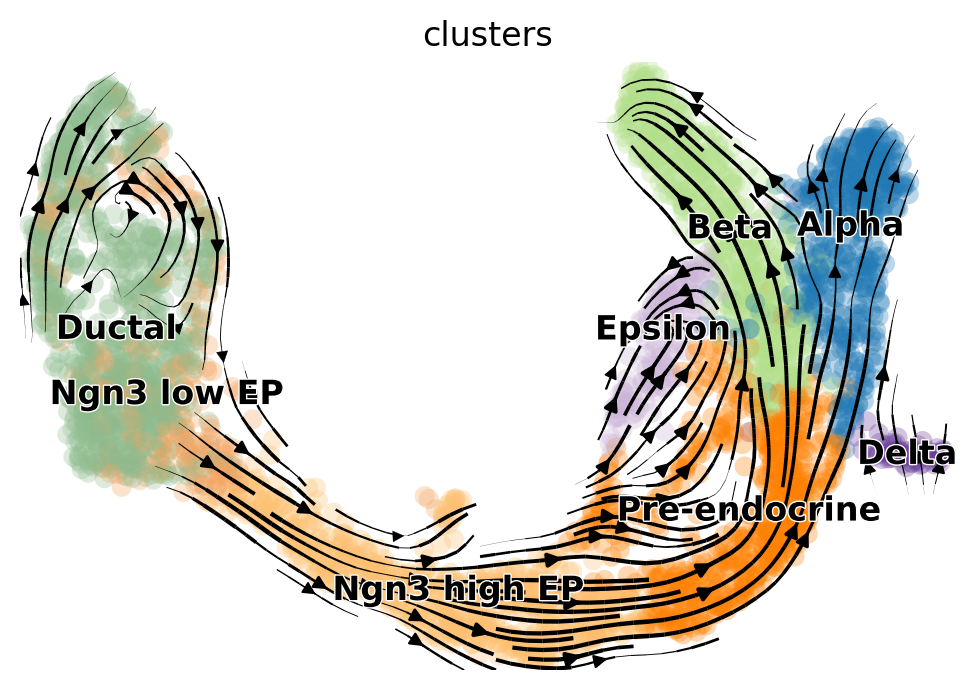

computing terminal states
    identified 2 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:01) --> added 
    'latent_time', shared time (adata.obs)


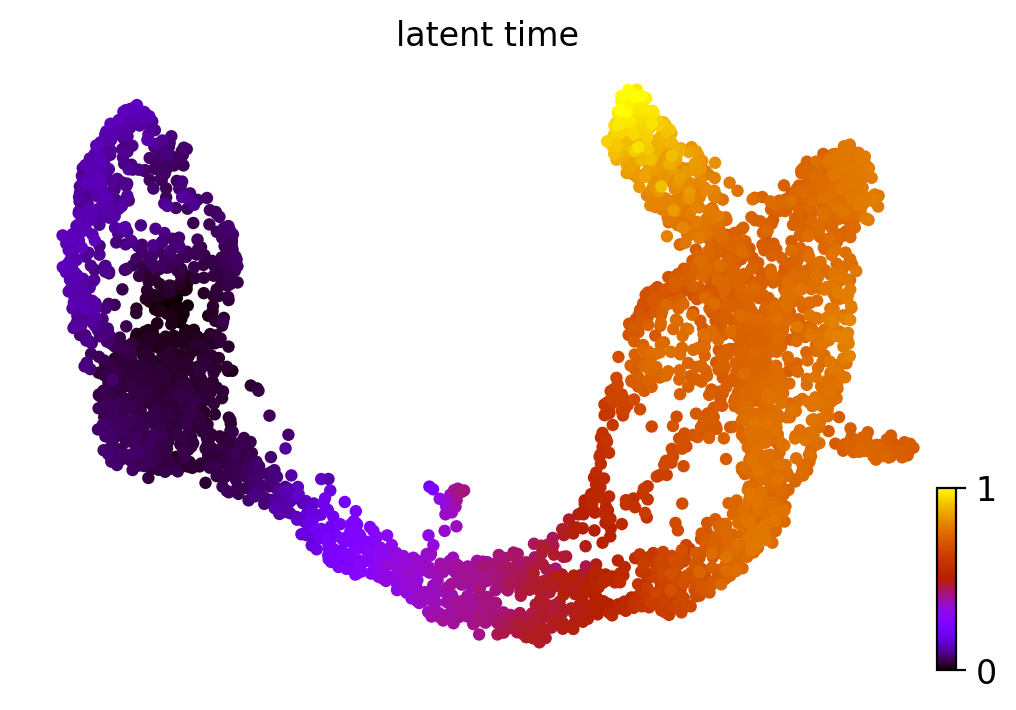

In [4]:
# Extract dynamical velocity vectors
scv.tl.recover_dynamics(adata, n_jobs=2)
scv.tl.velocity(adata, mode='dynamical', use_raw=True)
scv.tl.velocity_graph(adata, n_jobs=2)
scv.pl.velocity_embedding_stream(adata, basis='umap')

# Latent time inference
scv.tl.latent_time(adata)
scv.pl.scatter(adata, color='latent_time', color_map='gnuplot', size=80)

In [5]:
X = np.tile(adata_raw.X.A[:, adata.var["velocity_genes"]], (5, 1))
Y = np.tile(adata.layers["velocity"][:, adata.var["velocity_genes"]], (5, 1))
noise_sigma = (adata_raw.X.A.std()/70)**2
X[adata_raw.shape[0]:, :] += \
    np.random.normal(0, noise_sigma, X[adata_raw.shape[0]:, :].shape)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, 
                                                    Y, 
                                                    test_size=0.1, 
                                                    random_state=42)

# we see that noise has been added to denoise the autoencoder
print(X[:100])
print(X[adata_raw.shape[0]:(adata_raw.shape[0]+100), :])

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.8759722 0.        0.        ... 1.7519444 0.        0.       ]
 [0.        0.        0.        ... 0.        1.5218673 0.       ]
 ...
 [0.        0.        0.        ... 1.3494554 0.        0.       ]
 [0.5701924 0.5701924 0.        ... 4.561539  0.        0.       ]
 [0.        0.        0.        ... 0.9822391 0.        0.       ]]
[[ 3.31069948e-03 -5.58658876e-03  9.79977194e-03 ...  5.35742147e-03
   1.04569430e-02  4.21234872e-03]
 [ 8.81453812e-01  3.86451487e-04 -2.65926961e-03 ...  1.76388121e+00
  -8.32972582e-03 -2.66177952e-03]
 [-2.58495263e-03 -4.95831715e-03 -7.07113976e-03 ...  7.64016341e-03
   1.51588964e+00 -8.05833656e-03]
 ...
 [ 1.01943128e-02  7.62788719e-03  7.69944815e-03 ...  1.35446155e+00
   4.09666123e-03  1.52987279e-02]
 [ 5.86382926e-01  5.63273430e-01  1.11628305e-02 ...  4.56582308e+00
   1.27285141e-02  2.64340197e-03]
 [ 5.46750845e-03 -5.89456595e-03  8.21919180e-04 ...  9.81972

### Model Training

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
import numpy as np
import tensorflow as tf
import scipy 

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
input_dim = keras.Input(shape=(X.shape[1],))
encoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(input_dim)
encoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-2))(encoded)

decoded = layers.Dense(16, kernel_regularizer=keras.regularizers.l1(1e-4))(encoded)
decoded = layers.Dense(64, kernel_regularizer=keras.regularizers.l1(1e-6))(decoded)
decoded = layers.Dense(Y.shape[1])(decoded)

# This model maps an input to its reconstruction
encoder = keras.Model(input_dim, encoded)
autoencoder = keras.Model(input_dim, decoded)

opt = keras.optimizers.Adam(learning_rate=0.00007)
autoencoder.compile(optimizer=opt, loss='mse')
autoencoder.summary()

2021-10-13 21:24:29.046581: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-13 21:24:33.651231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15405 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:81:00.0, compute capability: 6.0


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1027)]            0         
_________________________________________________________________
dense (Dense)                (None, 64)                65792     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1088      
_________________________________________________________________
dense_4 (Dense)              (None, 1027)              66755     
Total params: 134,947
Trainable params: 134,947
Non-trainable params: 0
_____________________________________________________

In [8]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
autoencoder.fit(X_train, y_train,
        epochs=100,
        batch_size=2,
        shuffle=True,
        validation_data=(X_test, y_test),
        callbacks=[es])
autoencoder.save("total_kl.h5")

2021-10-13 21:24:34.821021: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
8316/8316 [==============================] - 19s 2ms/step - loss: 0.5301 - val_loss: 0.0503
Epoch 2/100
8316/8316 [==============================] - 15s 2ms/step - loss: 0.0423 - val_loss: 0.0372
Epoch 3/100
8316/8316 [==============================] - 14s 2ms/step - loss: 0.0356 - val_loss: 0.0345
Epoch 4/100
8316/8316 [==============================] - 14s 2ms/step - loss: 0.0339 - val_loss: 0.0334
Epoch 5/100
8316/8316 [==============================] - 14s 2ms/step - loss: 0.0331 - val_loss: 0.0328
Epoch 6/100
8316/8316 [==============================] - 15s 2ms/step - loss: 0.0325 - val_loss: 0.0324
Epoch 7/100
8316/8316 [==============================] - 15s 2ms/step - loss: 0.0320 - val_loss: 0.0321
Epoch 8/100
8316/8316 [==============================] - 15s 2ms/step - loss: 0.0317 - val_loss: 0.0317
Epoch 9/100
8316/8316 [==============================] - 15s 2ms/step - loss: 0.0314 - val_loss: 0.0315
Epoch 10/100
8316/8316 [==============================] - 14s 2m

### Total Divergence Calculations

In [9]:
from scipy.integrate import odeint, solve_ivp
import umap
import matplotlib.pyplot as plt

In [10]:
pca = sklearn.decomposition.PCA(n_components=30)
adata_pca = pca.fit_transform(np.log1p(adata_raw.X.A[:, adata.var["velocity_genes"]]))
umap_reducer = umap.UMAP(random_state=42)
adata_umap = umap_reducer.fit_transform(adata_pca)
neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=30)
neigh.fit(adata_pca)

# ODE Solver Function
def raw_ae(t, in_x):
    input_x = tf.convert_to_tensor(np.expand_dims(in_x, axis=0))
    dx = autoencoder.predict(input_x).flatten()
    return dx

# Interpolate over time
def interpolate(y0, neigh=neigh, pca=pca, umap_reducer=umap_reducer, steps=30, intermediate_steps=5):
    
    solution = []
    for step in range(steps):
        
        # Interpolate using autoencoder
        t_eval = list(range(intermediate_steps))
        sol = solve_ivp(raw_ae, [0,max(t_eval)], y0, method="RK23", t_eval=t_eval)
        y = sol.y.T
        
        # Lower dimensionality
        ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y)))
        
        # Find knn reference points
        interp_neigh = neigh.kneighbors(ending_pt_pca)
        
        # New reference point
        y0 = np.median(X[interp_neigh[1][-1, :], :], axis=0)
        solution.append(y0)
    
    return np.array(solution)

In [ ]:
all_paths = np.zeros((adata[:, adata.var["velocity_genes"]].shape[0], 
                      30, 
                      adata[:, adata.var["velocity_genes"]].shape[1]))
for i in range(adata.shape[0]):
    print(i)
    if (i % 50 == 0):
        with open('all_paths.npy', 'wb') as f:
            np.save(f, all_paths)
    all_paths[i, :, :] = interpolate(adata_raw.X[i, adata.var["velocity_genes"]].A.flatten(), 
                                     neigh = neigh, 
                                     pca = pca, 
                                     umap_reducer = umap_reducer)

with open('all_paths.npy', 'wb') as f:
    np.save(f, all_paths)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195


2021-10-13 22:40:50.680399: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445


1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195


In [55]:
a = all_paths[i, j, :] / all_paths[i, j, :].sum()
b = all_paths[i, j+1, :] / all_paths[i, j+1, :].sum()
c = scipy.special.rel_entr(a,b)
c[c == np.inf] = 0
np.sum(c)

0.00979516002319257

In [73]:
import scipy
all_paths_entropy = np.zeros(adata[:, adata.var["velocity_genes"]].shape[0])
for i in range(all_paths.shape[0]):
    for j in range(29):
        a = all_paths[i, j, :] / all_paths[i, j, :].sum()
        b = all_paths[i, j+1, :] / all_paths[i, j+1, :].sum()
        c = scipy.special.kl_div(a,b)
        c[c == np.inf] = 0
        all_paths_entropy[i] += np.sum(c)
print(all_paths_entropy)


[1.01247437 0.35090851 1.16557689 ... 0.1003865  0.66821468 1.12118174]


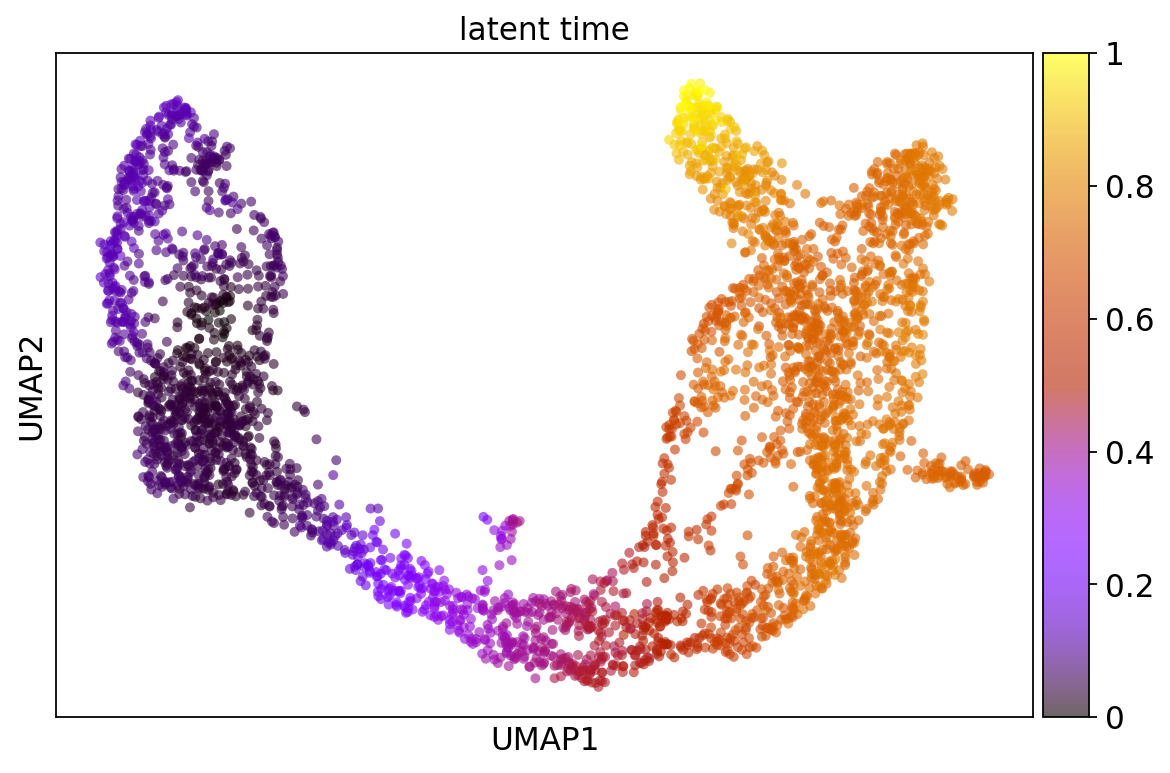

In [116]:
sc.pl.scatter(adata, color=['latent_time'], basis="umap", 
              color_map='gnuplot', size=80, save="latent_time", alpha=0.6)

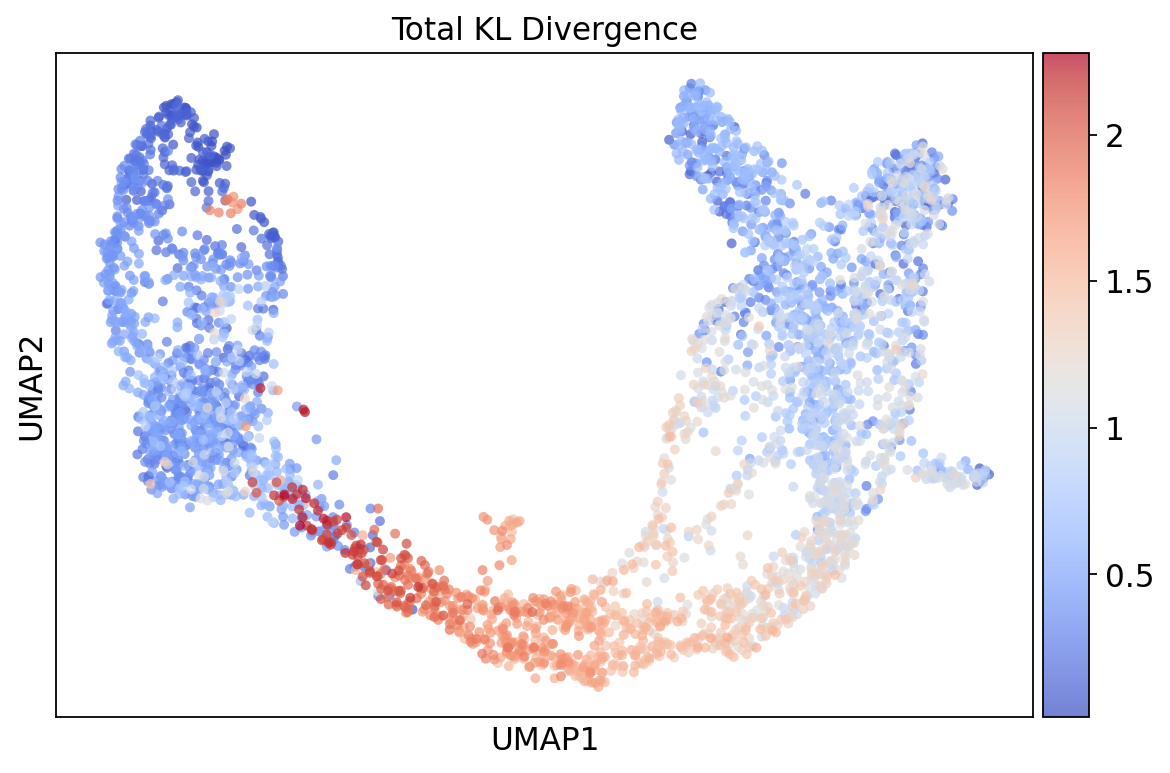

In [136]:
adata.obs["Total KL Divergence"] = all_paths_entropy
sc.set_figure_params(figsize=(7,5))
sc.pl.scatter(adata, color=["Total KL Divergence"], 
              basis="umap", color_map="coolwarm", save="total_kl", size=80, alpha=0.7)

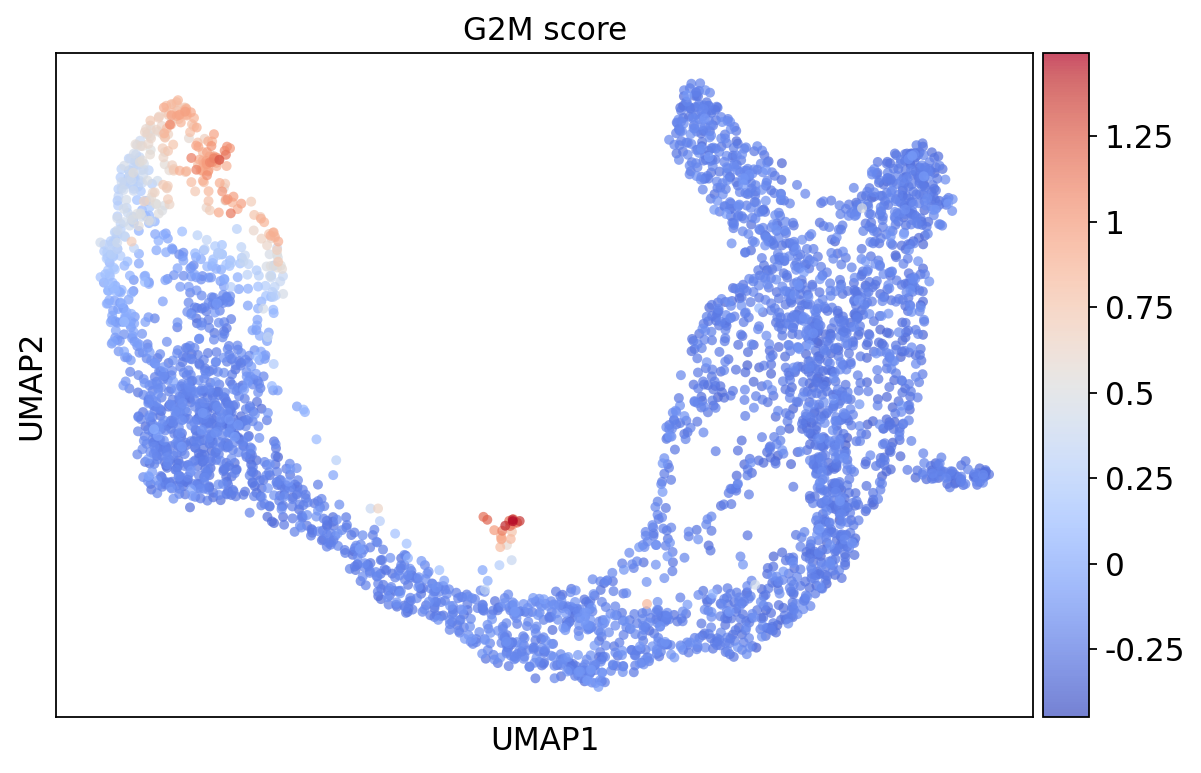

In [137]:
sc.pl.scatter(adata, color=["G2M_score"], 
              basis="umap", color_map="coolwarm", save="G2M", size=80, alpha=0.7)

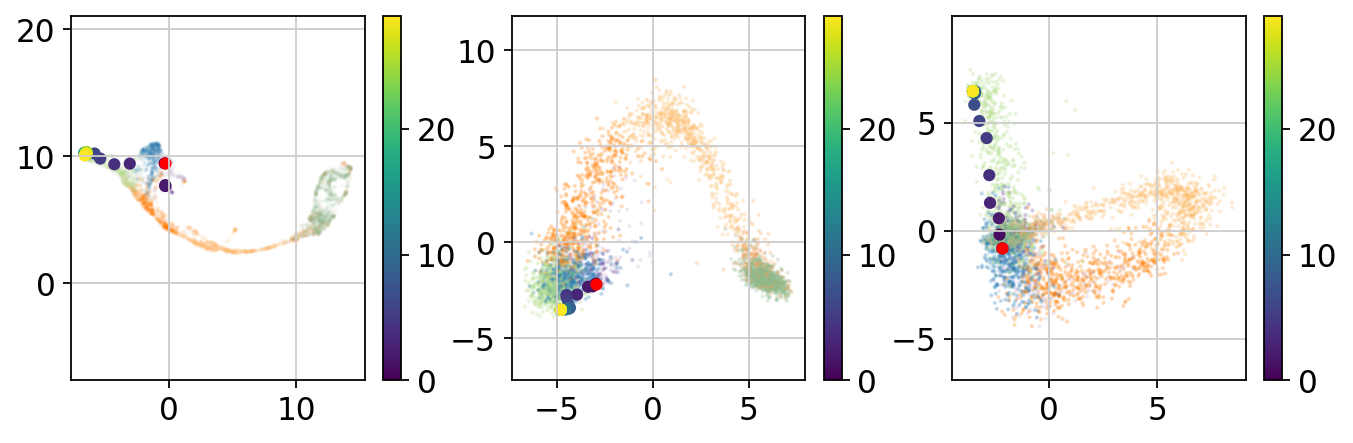

In [97]:
y_solution = all_paths[120]
# Lower dimensionality
ending_pt_pca = pca.transform(np.nan_to_num(np.log1p(y_solution)))
ending_pt = umap_reducer.transform(ending_pt_pca)
        
# Plot UMAP directions
plt.figure(figsize=(10,3))
plt.subplot(1, 3, 1)
plt.scatter(adata_umap[:, 0], adata_umap[:, 1], 
            s=1, alpha=0.05,
            c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt[:, 0], 
            ending_pt[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt[0, 0], ending_pt[0, 1], s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

# Plot PCA directions
plt.subplot(1, 3, 2)
plt.scatter(adata_pca[:, 0], 
            adata_pca[:, 1], 
            s=1, 
            alpha=0.2, 
            c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt_pca[:, 0], 
            ending_pt_pca[:, 1], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 0], ending_pt_pca[0, 1], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')

plt.subplot(1, 3, 3)
plt.scatter(adata_pca[:, 1], 
            adata_pca[:, 2], 
            s=1, 
            alpha=0.2, c=adata.uns["clusters_colors"][adata.obs.clusters.cat.codes.to_numpy()])
plt.scatter(ending_pt_pca[:, 1], 
            ending_pt_pca[:, 2], 
            c=np.arange(ending_pt.shape[0]), 
            cmap="viridis",
            s=20
           )
plt.colorbar()
plt.scatter(ending_pt_pca[0, 1], ending_pt_pca[0, 2], 
            s=20, color="red")
plt.gca().set_aspect('equal', 'datalim')
plt.show()